# Проект "Flat price prediction". Часть 2: Построение модели.

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import re
from datetime import datetime
from pprint import pprint

In [2]:
import ipython_exit as ie
import helper_v31102020 as utils

In [3]:
import locale
import copy

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor

In [6]:
#Выставим опции pandas для удобства просмотра
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
RANDOM_SEED = 42

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## 1. Загрузка данных

In [10]:
PATH_to_file = './data/'

In [11]:
lst_files = os.listdir(PATH_to_file)

In [12]:
data_all = []

for fl in lst_files:
    data = pd.read_csv(PATH_to_file + fl)
    data_all.append(data)

df = pd.concat(data_all)

In [13]:
df.sample()

,id,page,url,district,live_rooms,title,price,address,text_preview,owner,stats_city,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,pars_date,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text
1279,664547534,65,https://krisha.kz/a/show/664547534,almaty-almalinskij,3.0,"3-комнатная квартира, 134 м², 8/18 этаж",60000000,"Алмалинский р-н, Брусиловского 144","жил. комплекс Манхеттан (29 квартал), монолитный дом, 2007 г.п., состояние: евроремонт, жил. площадь 86.4 кв.м., кухня 12.6 кв.м., потолки 3м., санузел 2 с/у и более, телефон: нет, интернет ADSL, ...",Хозяин недвижимости,Алматы,11 мар.,0,0,0,0,0,0,14-03-2021 12:38:03,"монолитный, 2007 г.п.",8 из 18,"134 м², жилая — 86.4 м², кухня — 12.6 м²",евроремонт,2 с/у и более,балкон,да,Манхеттен (29 квартал),деревянная,ADSL,полностью меблирована,ламинат,3 м,"домофон, видеодомофон",Возможен обмен,нет,паркинг,нет,NaN,Торг


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147029 entries, 0 to 4
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               147029 non-null  int64  
 1   page             147029 non-null  int64  
 2   url              147029 non-null  object 
 3   district         147029 non-null  object 
 4   live_rooms       147029 non-null  float64
 5   title            147029 non-null  object 
 6   price            147029 non-null  int64  
 7   address          147029 non-null  object 
 8   text_preview     147029 non-null  object 
 9   owner            147029 non-null  object 
 10  stats_city       147029 non-null  object 
 11  ad_date          147029 non-null  object 
 12  paid_hot         147029 non-null  int64  
 13  paid_up          147029 non-null  int64  
 14  paid_fast        147029 non-null  int64  
 15  paid_urgent      147029 non-null  int64  
 16  paid_turbo       147029 non-null  int64  
 

<AxesSubplot:>

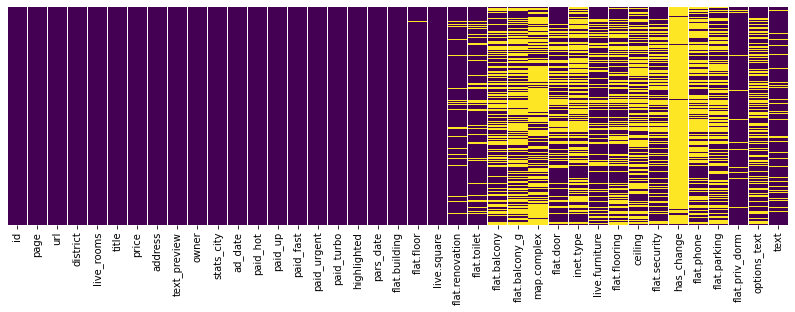

In [15]:
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

Перед обработкой сохраним оригинальный датасет

In [16]:
data = copy.deepcopy(df)

### Устранение дублей

In [17]:
df.id.value_counts(ascending=True)[:3]

665593861    1
665652204    1
665916399    1
Name: id, dtype: int64

In [18]:
valuable_columns = list(df.columns)
valuable_columns.remove('id')
valuable_columns.remove('page')
valuable_columns.remove('url')
valuable_columns.remove('ad_date')
valuable_columns.remove('pars_date')
print(valuable_columns)

['district', 'live_rooms', 'title', 'price', 'address', 'text_preview', 'owner', 'stats_city', 'paid_hot', 'paid_up', 'paid_fast', 'paid_urgent', 'paid_turbo', 'highlighted', 'flat.building', 'flat.floor', 'live.square', 'flat.renovation', 'flat.toilet', 'flat.balcony', 'flat.balcony_g', 'map.complex', 'flat.door', 'inet.type', 'live.furniture', 'flat.flooring', 'ceiling', 'flat.security', 'has_change', 'flat.phone', 'flat.parking', 'flat.priv_dorm', 'options_text', 'text']


In [19]:
df.drop_duplicates(subset=valuable_columns, inplace=True, keep='last', ignore_index=True)

In [20]:
len(df)

92528

### Столько объявлений останется, если оставить только "значимые столбцы" и удалить дубли.

## 2. Обработка признаков

### Удаляем неинформативные признаки

In [21]:
df.drop(['id', 'page', 'url', 'pars_date', 'stats_city'], axis=1, inplace=True)

### "Закодируем" первую группу категориальных признаков без пропусков (Label Encoding)

In [22]:
cat_f_1 = ['district', 'owner']

In [23]:
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 almaty-bostandykskij    28676
almaty-aujezovskij      18990
almaty-almalinskij      18501
almaty-medeuskij        10231
almaty-alatauskij        5003
almaty-nauryzbajskiy     3983
almaty-zhetysuskij       3979
almaty-turksibskij       3165
Name: district, dtype: int64 

owner 7 
 Специалист                54629
Хозяин недвижимости       22119
Проверенный специалист     9853
Проверенная компания       2977
Компания                   2877
Специалист оштрафован        49
На проверке                  24
Name: owner, dtype: int64 



In [24]:
# Кодируем категориальные признаки
for col in cat_f_1:
    df[col] = df[col].astype('category').cat.codes

In [25]:
#Проверяем
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 3    28676
2    18990
1    18501
4    10231
0     5003
5     3983
7     3979
6     3165
Name: district, dtype: int64 

owner 7 
 4    54629
6    22119
3     9853
2     2977
0     2877
5       49
1       24
Name: owner, dtype: int64 



### Теперь из признаков live_rooms, title, flat.floor и live.square нужно получить количество комнат, площади, этаж, на котором находится квартира и количество этажей в доме. Также, будут полезны новые признаки, как Первый этаж, Последний этаж, Отношение площади к количеству комнат.

Определяем функции

In [26]:
def extract_live_rooms(str_title):
    return int(str_title.split(', ', 2)[0].split('-', 1)[0])

In [27]:
def extract_total_square(str_title):
    return float(str_title.split(', ', 2)[1].split(' м²', 1)[0])

In [28]:
def extract_total_square1(str_title):
    return float(str_title.split(', ', 2)[0].split(' м²', 1)[0])

In [29]:
def extract_living_square(str_title):
    if 'жилая' in str_title:
        return float(str_title.split(', ', 2)[1].split('жилая — ', 1)[1].split(' м²', 1)[0])
    else:
        return 0.0

In [30]:
def extract_kitchen_square(str_title):
    if 'кухня' in str_title:
        if 'жилая' in str_title:
            return float(str_title.split(', ', 2)[2].split('кухня — ', 1)[1].split(' м²', 1)[0])
        else:
            return float(str_title.split(', ', 2)[1].split('кухня — ', 1)[1].split(' м²', 1)[0])
        
    else:
        return 0.0

In [31]:
def extract_flat_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[0])
        else:
            return int(temp_str.split(' этаж', 1)[0])
    else:
        return 0

In [32]:
def extract_building_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[1].split(' этаж', 1)[0])
        else:
            return 0
    else:
        #print(str_title)
        return 0

In [33]:
def extract_flat_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[0])
        else:
            return int(str_flat_floor_temp)
    else:
        return 0

In [34]:
def extract_building_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[1])
        else:
            return 0
    else:
        return 0

Извлекаем и проверяем признаки

### live_rooms

In [35]:
df['live_rooms1'] = df.title.apply(lambda x: extract_live_rooms(x))

In [36]:
df_temp = df[df.live_rooms <= 4]
df_temp[(df_temp.live_rooms - df_temp.live_rooms1) != 0]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1


Эта проверка показывает, что мы правильно извлекли количество комнат из заголовка объявления

In [37]:
df.live_rooms = df.live_rooms1

**total_square, living_square, kitchen_square**

In [38]:
df['total_square'] = df.title.apply(lambda x: extract_total_square(x))

In [39]:
df['total_square1'] = df['live.square'].apply(lambda x: extract_total_square1(x))

In [40]:
df[df.total_square != df.total_square1]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1


Колонки total_square и total_square1 совпадают

In [41]:
df['living_square'] = df['live.square'].apply(lambda x: extract_living_square(x))

In [42]:
df['kitchen_square'] = df['live.square'].apply(lambda x: extract_kitchen_square(x))

### flat_floor

In [43]:
df['flat_floor'] = df.title.apply(lambda x: extract_flat_floor(x))

In [44]:
df['flat_floor1'] = df['flat.floor'].apply(lambda x: extract_flat_floor1(x))

In [45]:
df['flat_floor'] = np.where(df['flat_floor'] == 0, df['flat_floor1'], df['flat_floor'])

In [46]:
df[df['flat_floor'] != df['flat_floor1']]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1,living_square,kitchen_square,flat_floor,flat_floor1


Теперь колонки flat_floor и flat_floor1 совпадают

### building_floor

In [47]:
df['building_floor'] = df.title.apply(lambda x: extract_building_floor(x))

In [48]:
df['building_floor1'] = df['flat.floor'].apply(lambda x: extract_building_floor1(x))

In [49]:
df[df['building_floor'] != df['building_floor1']]

,district,live_rooms,title,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,live_rooms1,total_square,total_square1,living_square,kitchen_square,flat_floor,flat_floor1,building_floor,building_floor1


Колонки building_floor и building_floor1 совпадают

Удалим "лишние" колонки:

In [50]:
df.drop(['live_rooms1', 'flat_floor1', 'flat.floor', 'title', 'building_floor1', 'live.square', 'total_square1'], axis=1, inplace=True)

Теперь еще раз удалим дубли, так как состав столбцов изменился
**Здесь нужно подбирать способ удаления дублей, состав столбцов для уникальности!**

In [51]:
valuable_columns = \
['district', 'live_rooms', 'price', 'owner', 'flat.building', 'total_square', 'flat_floor', 'building_floor']

In [52]:
df.drop_duplicates(subset=valuable_columns, inplace=True, keep='last', ignore_index=True)
len(df)

61328

**Теперь посмотрими на значения признаков live_rooms, total_square, living_square, kitchen_square, flat_floor, building_floor и обработаем аномальные значения (выбросы).**

### live_rooms

In [53]:
df.live_rooms.value_counts(dropna=False)

2     21512
3     20174
1     14135
4      4434
5       719
6       191
7        84
8        35
9        21
12       11
10        8
20        1
14        1
11        1
32        1
Name: live_rooms, dtype: int64

Видно, что квартиры с количеством комнат > 8 представлены очень малым числом объявлений. Точность модели на таких примерах будет низкой. Удалим их.

In [54]:
df.drop(df[df.live_rooms > 8].index, inplace=True)

Количество: 61284, Среднее: 2.301, Стандартное отклонение: 0.984.
Минимум: 1, 25-й перцентиль: 2.0, Медиана: 2.0, 75-й перцентиль: 3.0, Максимум: 8, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.5, 4.5]. Количество выбросов:  1029


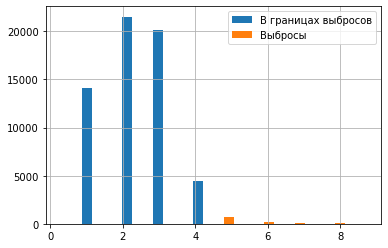

In [55]:
utils.analyse_numeric(df, 'live_rooms')

**Здесь, возможно, нужно удалить все записи со значением live_rooms > 4**

In [56]:
df.drop(df[df.live_rooms > 4].index, inplace=True)

In [57]:
len(df)

60255

### total_square

Количество: 60255, Среднее: 66.569, Стандартное отклонение: 33.075.
Минимум: 8.97, 25-й перцентиль: 44.0, Медиана: 60.0, 75-й перцентиль: 78.0, Максимум: 450.0, IQR: 34.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7.0, 129.0]. Количество выбросов:  3409


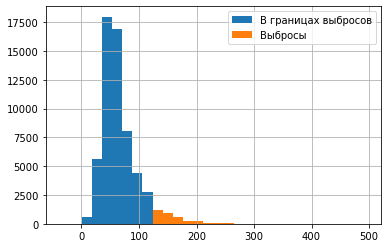

In [58]:
utils.analyse_numeric(df, 'total_square')

Квартиры с площадью > 180 м² будем считать аномалиями. **Это значение нужно подбирать** 

In [59]:
df.drop(df[df.total_square > 180].index, inplace=True)

### living_square и kitchen_square

In [60]:
df.loc[df.living_square >= df.total_square, 'living_square'] = 0

Количество: 59657, Среднее: 14.646, Стандартное отклонение: 22.302.
Минимум: 0.0, 25-й перцентиль: 0.0, Медиана: 0.0, 75-й перцентиль: 28.4, Максимум: 162.4, IQR: 28.4.
Количество пропусков в столбце:  0
Границы выбросов: [-42.599999999999994, 71.0]. Количество выбросов:  1432


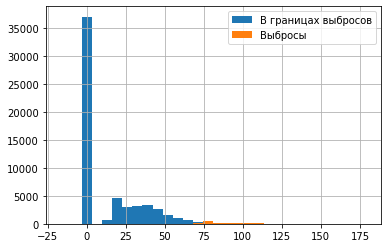

In [61]:
utils.analyse_numeric(df, 'living_square')

Признак **living_square** не так важен и содержит много пропусков. Лучше его удалить.

In [62]:
df.drop(['living_square'], axis=1, inplace=True)

In [63]:
df.loc[df.kitchen_square >= df.total_square, 'kitchen_square'] = 0

In [64]:
len(df[df.kitchen_square == 0])

19954

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [65]:
#df.loc[df.kitchen_square == 0, 'kitchen_square'] = df.kitchen_square.median()

Количество: 59657, Среднее: 6.752, Стандартное отклонение: 6.038.
Минимум: 0.0, 25-й перцентиль: 0.0, Медиана: 6.0, 75-й перцентиль: 10.7, Максимум: 80.0, IQR: 10.7.
Количество пропусков в столбце:  0
Границы выбросов: [-16.049999999999997, 26.749999999999996]. Количество выбросов:  287


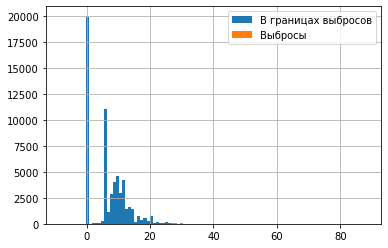

In [66]:
utils.analyse_numeric(df, 'kitchen_square', bns=100)

### flat_floor

In [67]:
df['flat_floor'].value_counts(dropna=False)

2     8980
4     8365
3     8295
1     7704
5     7521
6     2879
8     2811
9     2787
7     2769
10    1618
12    1155
11    1041
0      770
13     574
14     557
16     518
15     503
17     245
18     180
19     137
20      90
21      80
25      23
22      22
23      11
24      10
26       6
27       2
99       1
77       1
58       1
70       1
Name: flat_floor, dtype: int64

In [68]:
df[df['flat_floor'] > 25]

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
13393,1,3,35000000,"Алмалинский р-н, проспект Райымбека 243","монолитный дом, 2007 г.п., состояние: евроремонт, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована",6,25 мар.,0,0,0,0,0,0,"монолитный, 2007 г.п.",евроремонт,раздельный,лоджия,да,NaN,металлическая,ADSL,частично меблирована,линолеум,2.8 м,"домофон, видеонаблюдение",NaN,отдельный,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор, кондиционер.",NaN,75.0,14.0,77,9
23088,2,3,28499900,"Ауэзовский р-н, мкр Жетысу-1, Мкр Жетысу-1","панельный дом, 1989 г.п., состояние: хорошее, жил. площадь 55 кв.м., кухня 15 кв.м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована, ВНИМАНИЕ! 3-х комнатная квартира в...",4,13 мар.,0,0,0,0,0,0,"панельный, 1989 г.п.",хорошее,раздельный,балкон и лоджия,да,NaN,металлическая,ADSL,частично меблирована,NaN,NaN,домофон,NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, новая сантехника, счётчики, тихий двор.","ВНИМАНИЕ! 3-х комнатная квартира в одном из самых востребованных районов города. Соотношение ЦЕНА-СОСТОЯНИЕ-расположенИЕ! \nРазвитая инфраструктура, квартира и район со всеми удобствами для жизни,...",70.0,15.0,99,0
30960,3,2,79000000,"Бостандыкский р-н, Аль-Фараби","жил. комплекс Orion, монолитный дом, 2018 г.п., состояние: евроремонт, санузел 2 с/у и более, телефон: отдельный, интернет оптика, полностью меблирована, Эксклюзивное предложение от агентства «Dem...",2,2 мар.,1,0,0,0,0,0,"монолитный, 2018 г.п.",евроремонт,2 с/у и более,NaN,NaN,Orion,бронированная,оптика,полностью меблирована,ламинат,NaN,"охрана, кодовый замок, сигнализация, видеонаблюдение, видеодомофон, консьерж",NaN,отдельный,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, кладовка, счётчики, кондиционер.","Эксклюзивное предложение от агентства «Demetra» -Продается шикарная квартира в жк ""ORION"", расположенный в экологически чистом и элитном районе города. Эксклюзивный дизайн интерьера выполнен в спо...",87.0,16.0,26,33
31280,3,2,75000000,"Бостандыкский р-н, Аль-Фараби","жил. комплекс Orion, монолитный дом, 2018 г.п., состояние: евроремонт, потолки 3м., санузел 2 с/у и более, телефон: отдельный, интернет ADSL, полностью меблирована, Пластиковые окна, неугловая, ул...",3,28 февр.,1,0,0,0,0,0,"монолитный, 2018 г.п.",евроремонт,2 с/у и более,лоджия,NaN,Orion,бронированная,ADSL,полностью меблирована,ламинат,3 м,видеодомофон,NaN,отдельный,NaN,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, кладовка, счётчики, тихий двор, кондиционер.","Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, кладовка, счётчики, кондиционер. \nЭксклюзивное предложение от агентства «Demetra» -Продается шика...",87.0,16.0,26,33
31533,3,2,59000000,"Бостандыкский р-н, мкр Нурлытау (Энергетик) 7 — проспект Аль-Фараби","жил. комплекс Нурлы Тау, монолитный дом, 2005 г.п., состояние: хорошее, потолки 2.85м., санузел 2 с/у и более, телефон: отдельный, интернет ADSL, частично меблирована, Вид на Коктобе",6,13 мар.,0,0,0,0,0,0,"монолитный, 2005 г.п.",хорошее,2 с/у и более,NaN,NaN,Нурлы Тау,металлическая,ADSL,частично меблирована,ламинат,2.85 м,"охрана, домофон, видеонаблюдение, консьерж",NaN,отдельный,NaN,NaN,"Пластиковые окна, кухня-студия, новая сантехника, счётчики, тихий двор, кондиционер, удобно под коммерцию.",Вид на Коктобе,94.0,0.0,26,32
33807,3,2,54000000,"Бост

Визуальный просмотр показывает, что объявления по квартирам со значением этажа > 25 содержат ошибки, дубли и их мало. Удалим записи со значением > 20.

In [69]:
df.drop(df[df.flat_floor > 20].index, inplace=True)

Количество: 59499, Среднее: 4.878, Стандартное отклонение: 3.644.
Минимум: 0, 25-й перцентиль: 2.0, Медиана: 4.0, 75-й перцентиль: 7.0, Максимум: 20, IQR: 5.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5.5, 14.5]. Количество выбросов:  1673


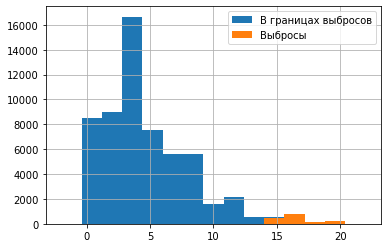

In [70]:
utils.analyse_numeric(df, 'flat_floor', bns=15)

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [71]:
df.loc[df.flat_floor == 0, 'flat_floor'] = df.flat_floor.median()

### building_floor

In [72]:
df['building_floor'].value_counts(dropna=False)

5      16138
9       8609
4       8293
12      4625
10      3283
16      2709
13      1828
3       1794
0       1633
6       1546
2       1146
14      1074
15       921
18       907
17       891
7        853
8        845
21       682
11       403
20       400
25       281
22       246
19       178
1        111
23        30
33        29
30        24
29         4
32         4
24         2
31         2
100        1
28         1
252        1
98         1
121        1
54         1
76         1
49         1
Name: building_floor, dtype: int64

In [73]:
df[df['building_floor'] > 33]

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
7771,1,2,25500000,"Алмалинский р-н, Макатаева (Пастера) — Абылай хана (Коммунистический)","кирпичный дом, 1979 г.п., состояние: среднее, жил. площадь 30 кв.м., кухня 9 кв.м., санузел раздельный, пустая, (№61387) 2 КОМТНАТНАЯ улУЧШЕННОЙ ПЛАНИРОВКИ, НЕУГЛОВАЯ КВАРТИРА. Удобная транспортна...",4,20 мар.,0,0,0,0,0,0,"кирпичный, 1979 г.п.",среднее,раздельный,NaN,NaN,NaN,NaN,NaN,пустая,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"(№61387) 2 КОМТНАТНАЯ улУЧШЕННОЙ ПЛАНИРОВКИ, НЕУГЛОВАЯ КВАРТИРА. Удобная транспортная развязка. Развитая инфраструктура - магазины, школы, банки, аптеки, детские сады, поликлиники. Квартиру можно ...",49.4,9.0,5,49
18172,2,2,25000000,"Ауэзовский р-н, мкр Аксай-1 25","монолитный дом, 1994 г.п., состояние: хорошее, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет ADSL, частично меблирована, Срочно! Продам отличную 2-х комнатную квартиру, в ХОРОШЕМ...",4,5 мар.,1,0,0,1,0,0,"монолитный, 1994 г.п.",хорошее,раздельный,балкон,да,NaN,металлическая,ADSL,частично меблирована,линолеум,2.8 м,"домофон, видеонаблюдение",NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор.","Срочно! Продам отличную 2-х комнатную квартиру, в ХОРОШЕМ СОСТОЯНИИ. \nОтличное расположение, рядом всё в шаговой доступности.",57.0,10.0,7,121
30350,3,2,31000000,"Бостандыкский р-н, Каблукова 264","жил. комплекс Mega Tower Almaty, монолитный дом, 2016 г.п., состояние: хорошее, потолки 2.8м., санузел совмещенный, телефон: отдельный, интернет ADSL, полностью меблирована",4,5 мар.,0,0,0,0,0,0,"монолитный, 2016 г.п.",хорошее,совмещенный,балкон,да,Mega Tower Almaty,металлическая,ADSL,полностью меблирована,ламинат,2.8 м,"охрана, домофон, сигнализация, видеонаблюдение",NaN,отдельный,паркинг,нет,"Пластиковые окна, неугловая, кухня-студия, встроенная кухня, новая сантехника, кладовка, счётчики, тихий двор, кондиционер.",NaN,50.0,0.0,7,252
33731,3,2,35800000,"Бостандыкский р-н, Жамбыла","жил. комплекс Алма-Ата, монолитный дом, 2015 г.п., состояние: хорошее, потолки 3м., санузел совмещенный, телефон: отдельный, интернет ADSL, полностью меблирована, Отличная квартира по хорошей цене...",4,15 мар.,0,0,0,0,0,0,"монолитный, 2015 г.п.",хорошее,совмещенный,NaN,NaN,Алма-Ата,бронированная,ADSL,полностью меблирована,NaN,3 м,домофон,NaN,отдельный,паркинг,нет,"Пластиковые окна, кухня-студия, встроенная кухня, новая сантехника, тихий двор.","Отличная квартира по хорошей цене в ЖК Алма-Ата! Развитая инфраструктура, рядом школы, детсады, остановки, станция метро, ТРЦ Глобус, и т.д. \nОтличный вариант на сдачу или для семейной пары. \nПо...",62.0,0.0,5,98
37709,3,3,50100000,"Бостандыкский р-н, Навои","жил. комплекс Тау Самал на Навои, монолитный дом, 2011 г.п., состояние: хорошее, жил. площадь 55 кв.м., кухня 19 кв.м., потолки 3м., санузел раздельный, частично меблирована, От специалиста компан...",4,2 мар.,0,0,0,0,0,0,"монолитный, 2011 г.п.",хорошее,раздельный,NaN,NaN,Тау Самал на Навои,NaN,NaN,частично меблирована,NaN,3 м,домофон,NaN,NaN,паркинг,нет,"Пластиковые окна, неугловая, улучшенная, встроенная кухня, новая сантехника, счётчики.","От специалиста компании ""ATRIUM"" продается квартира в уютном доме. Дом каркасно-монолитный, 2011 года, состояние отличное. Квартира не залоговая, улучшенная, комнаты изолированные, большой благоус...",103.0,19.0,3,100
39707,3,3,75000000,"Бостандыкский р-н, проспект Гагарина","монолитный дом, 2018 г.п., состояние: евроремонт, санузел 2 с/у и более, интернет проводной, полностью меблирована",4,19 мар.,0,0,0,0,0,0,"монолитный, 2018 г.п.",евроремонт,

Удалим записи со значением > 33

In [74]:
df.drop(df[df.building_floor > 33].index, inplace=True)

**Можно попробовать заменить пропуски медианой, либо оставить значение нулевым (0)**

In [75]:
df.loc[df.building_floor == 0, 'building_floor'] = df.building_floor.median()

Количество: 59492, Среднее: 8.270, Стандартное отклонение: 4.693.
Минимум: 1, 25-й перцентиль: 5.0, Медиана: 6.0, 75-й перцентиль: 11.0, Максимум: 33, IQR: 6.0.
Количество пропусков в столбце:  0
Границы выбросов: [-4.0, 20.0]. Количество выбросов:  1305


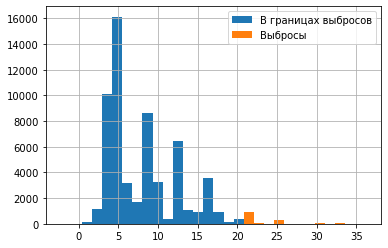

In [76]:
utils.analyse_numeric(df, 'building_floor')

In [77]:
df.sample(1)

,district,live_rooms,price,address,text_preview,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor
58317,6,3,21400000,"Турксибский р-н, мкр Жулдыз-1","панельный дом, 1983 г.п., состояние: хорошее, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет оптика, частично меблирована, Продам светлую, уютную, хорошую 3-х комнатную квартиру в...",6,22 мар.,0,0,0,0,0,0,"панельный, 1983 г.п.",хорошее,раздельный,балкон и лоджия,да,NaN,металлическая,оптика,частично меблирована,линолеум,2.8 м,кодовый замок,NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, счётчики, тихий двор, кондиционер.","Продам светлую, уютную, хорошую 3-х комнатную квартиру в м-н ""Жулдыз-1"". НЕ УГЛОВАЯ! НЕ ЗАЛОГОВАЯ! ВТОРОЙ ЭТАЖ. Зимой тепло! Двери деревянные, мебель из дерева белорусская. Балконы остеклены с уте...",67.6,12.0,2,3


### price - целевая переменная

Количество: 59492, Среднее: 32996811.066, Стандартное отклонение: 21842496.452.
Минимум: 2500000, 25-й перцентиль: 20000000.0, Медиана: 26500000.0, 75-й перцентиль: 38500000.0, Максимум: 555000000, IQR: 18500000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7750000.0, 66250000.0]. Количество выбросов:  4143


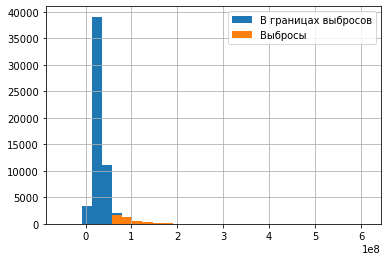

In [78]:
utils.analyse_numeric(df, 'price')

Квартиры ценой > 200000000 (200 млн. тенге) будем считать аномалиями. Это значение нужно подбирать

In [79]:
df.drop(df[df.price > 200000000].index, inplace=True)

Количество: 59456, Среднее: 32860125.841, Стандартное отклонение: 21046296.375.
Минимум: 2500000, 25-й перцентиль: 20000000.0, Медиана: 26500000.0, 75-й перцентиль: 38500000.0, Максимум: 200000000, IQR: 18500000.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7750000.0, 66250000.0]. Количество выбросов:  4107


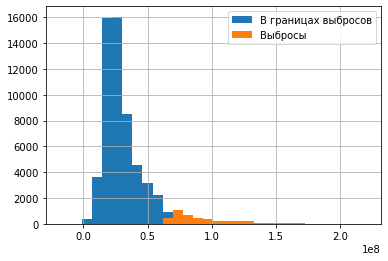

In [80]:
utils.analyse_numeric(df, 'price')

Порядок значений цены можно понизить, поделив все на 1000000.0

In [81]:
df.price = df.price / 1000000.0

Количество: 59456, Среднее: 32.860, Стандартное отклонение: 21.046.
Минимум: 2.5, 25-й перцентиль: 20.0, Медиана: 26.5, 75-й перцентиль: 38.5, Максимум: 200.0, IQR: 18.5.
Количество пропусков в столбце:  0
Границы выбросов: [-7.75, 66.25]. Количество выбросов:  4107


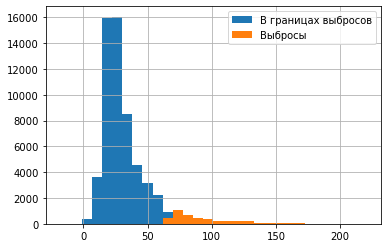

In [82]:
#plt.rcParams['figure.figsize'] = (10,7)
utils.analyse_numeric(df, 'price')

### ad_date - дата подачи объявления.
Возможно, нам пригодится признак days - количество дней между максимальной датой и датой подачи объявления, если, к примеру, квартиры со временем дорожают.

In [83]:
df.ad_date.value_counts()[:5]

26 мар.    5345
25 мар.    5124
27 мар.    4445
24 мар.    4436
23 мар.    4201
Name: ad_date, dtype: int64

In [84]:
loca = locale.getlocale()
loca

('Russian_Russia', '1251')

In [85]:
locale.setlocale(locale.LC_ALL, 'ru_RU')

'ru_RU'

In [86]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('.', ' 2021'))

In [87]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('февр', 'фев'))

In [88]:
df.ad_date.value_counts()[::6]

26 мар 2021    5345
9 мар 2021     2303
18 мар 2021    1789
11 мар 2021    1533
14 мар 2021     958
Name: ad_date, dtype: int64

In [89]:
df.ad_date = pd.to_datetime(df.ad_date, format = '%d %b %Y')

In [90]:
locale.setlocale(locale.LC_ALL, loca)

'Russian_Russia.1251'

In [91]:
min(df.ad_date), max(df.ad_date)

(Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-29 00:00:00'))

In [92]:
max_date = max(df.ad_date)
df['days'] = df.ad_date.apply(lambda x: (max_date - x).days + 1)

<AxesSubplot:>

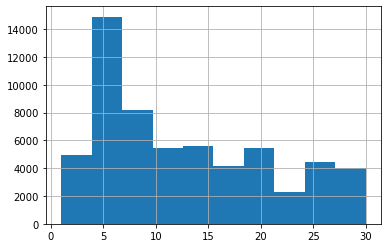

In [93]:
df.days.hist()

In [94]:
df.drop(['ad_date'], axis=1, inplace=True)

In [95]:
len(df)

59456

### flat.building

In [96]:
df['flat.building'].value_counts(dropna=False)

монолитный, 2016 г.п.    3904
монолитный, 2017 г.п.    3006
монолитный, 2018 г.п.    2212
монолитный, 2015 г.п.    2024
монолитный, 2020 г.п.    1641
                         ... 
кирпичный, 1930 г.п.        1
иное, 1984 г.п.             1
панельный, 1919 г.п.        1
монолитный, 1964 г.п.       1
панельный, 1958 г.п.        1
Name: flat.building, Length: 374, dtype: int64

In [97]:
df['flat.building'].isna().sum()

0

Извлечем Год постройки

In [98]:
def extract_building_year(str_year):
    arr_tmp = str_year.split(', ', 1)
    if len(arr_tmp) == 1:
        return int(arr_tmp[0].split(' г.п.', 1)[0])
    elif len(arr_tmp) == 2:
        return int(arr_tmp[1].split(' г.п.', 1)[0])
    else:
        print(str_year)
        return np.nan

In [99]:
def extract_building_type(str_year):
    arr_tmp = str_year.split(', ', 1)
    if len(arr_tmp) == 1:
        return 'unknown'
    elif len(arr_tmp) == 2:
        return arr_tmp[0]
    else:
        print(str_year)
        return None

In [100]:
PRESENT_YEAR = 2021

In [101]:
df['building_age'] = df['flat.building'].apply(lambda x: extract_building_year(x))

In [102]:
df[df.building_age < 1930]

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age
127,0,1,13.500,"Алатауский р-н, мкр Саялы 20","монолитный дом, 1915 г.п., состояние: хорошее, потолки 2.8м., санузел совмещенный, пустая, ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 Предлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно ра...",4,0,0,0,0,0,0,"монолитный, 1915 г.п.",хорошее,совмещенный,лоджия,NaN,NaN,металлическая,NaN,пустая,линолеум,2.8 м,NaN,NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, счётчики, тихий двор.","ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 \n \nПредлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно развивающемся районе. \nВсе удобства для жизни. Большая, просторная парковка, множество ...",40.0,10.0,5,6,27,1915
637,0,1,13.300,"Алатауский р-н, мкр Саялы, Мкр Саялы","монолитный дом, 1915 г.п., состояние: хорошее, потолки 2.8м., санузел совмещенный, пустая, ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 Предлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно ра...",4,1,0,0,0,0,0,"монолитный, 1915 г.п.",хорошее,совмещенный,лоджия,NaN,NaN,металлическая,NaN,пустая,линолеум,2.8 м,NaN,NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, счётчики, тихий двор.","ВНИМАНИЕ ЭКСКЛЮЗИВ 🔥 \n \nПредлагаем вам выгодно приобрести 1 комнатную улучшенную квартиру, в стремительно развивающемся районе. \nВсе удобства для жизни. Большая, просторная парковка, множество ...",40.0,10.0,4,5,13,1915
20603,2,2,20.500,"Ауэзовский р-н, мкр №6, Мкр №6 3А","панельный дом, 1919 г.п., состояние: хорошее, санузел совмещенный, Пластиковые окна, неугловая, комнаты изолированы. Дом расположен прямо по Абая, но окна выходят во двор. Пластиковые окна, решетк...",4,0,0,0,0,0,0,"панельный, 1919 г.п.",хорошее,совмещенный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Пластиковые окна, неугловая, комнаты изолированы. \nДом расположен прямо по Абая, но окна выходят во двор. Пластиковые окна, решетки. Балкон застеклен. Очень теплая. Район удобный с развитой инфра...",42.0,6.0,2,5,3,1919
22855,2,3,37.999,"Ауэзовский р-н, Саина 10/3","жил. комплекс Самга, монолитный дом, 1917 г.п., состояние: хорошее, потолки 2.7м., санузел раздельный, телефон: отдельный, частично меблирована, Срочная продажа, развитая инфраструктура, транспорт...",0,0,0,0,1,0,0,"монолитный, 1917 г.п.",хорошее,раздельный,балкон и лоджия,да,Самга,NaN,NaN,частично меблирована,ламинат,2.7 м,домофон,NaN,отдельный,рядом охраняемая стоянка,нет,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор.","Срочная продажа, развитая инфраструктура, транспорт в любую часть города",90.0,15.0,6,12,28,1917
24609,2,3,28.400,"Ауэзовский р-н, проспект Райымбека 508 — Саина","панельный дом, 1876 г.п., состояние: хорошее, санузел раздельный, Квартира находится в очень хорошем и развитом районе города. Сантехника в отличном состоянии. Квартира полностью готова к продаже....",4,0,0,0,0,0,0,"панельный, 1876 г.п.",хорошее,раздельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,Квартира находится в очень хорошем и развитом районе города. Сантехника в отличном состоянии. Квартира полностью готова к продаже. Идеальная транспортная развязка \n \nПодробнее по телефону!,65.0,8.0,1,8,3,1876
39986,3,3,80.000,"Бостандыкский р-н, мкр Баганашыл, Аль-Фараби 144","жил. комплекс Горное Солнце, монолитный дом, 1916 г.п., состояние: хорошее, жил. площадь 100 кв.м., кухня 20 кв.м., потолки 3м., санузел 2 с/у и более, телефон: отдельный, интернет оптика, частичн...",6,0,0,0,0,0,0,"монолитный, 1916 г.п.",хорошее,2 с/у и более,NaN,NaN,Горное Солнце,металлическая,оптика,частично меблирована,NaN,3 

Исправим ошибки в годе постройки и преобразуем к возрасту постройки + 1

In [103]:
df.building_age = df.building_age.apply(lambda x: x + 100 if x < 1930 else x)
df.building_age = (PRESENT_YEAR + 1) - df.building_age

In [104]:
df.building_age.value_counts()

6     4191
5     3262
4     2447
7     2215
2     1958
      ... 
92       2
86       1
85       1
91       1
87       1
Name: building_age, Length: 92, dtype: int64

Теперь извлечем Тип постройки (материал)

In [105]:
df['building_type'] = df['flat.building'].apply(lambda x: extract_building_type(x))

In [106]:
df.building_type.value_counts(dropna=False)

монолитный    26315
панельный     18058
кирпичный     11582
unknown        2793
иное            705
4                 3
Name: building_type, dtype: int64

In [107]:
df['building_type'] = df['building_type'].astype('category').cat.codes

In [108]:
df.building_type.value_counts(dropna=False)

4    26315
5    18058
3    11582
1     2793
2      705
0        3
Name: building_type, dtype: int64

In [109]:
df.drop(['flat.building'], axis=1, inplace=True)

### flat.priv_dorm

In [110]:
df['flat.priv_dorm'].value_counts(dropna=False)

нет    52509
NaN     5444
да      1503
Name: flat.priv_dorm, dtype: int64

In [111]:
df['flat_priv_dorm'] = df['flat.priv_dorm']

In [112]:
df.loc[df['flat_priv_dorm'].isna(), 'flat_priv_dorm'] = 'нет'

In [113]:
df['flat_priv_dorm'] = df['flat_priv_dorm'].astype('category').cat.codes

In [114]:
df['flat_priv_dorm'].value_counts(dropna=False)

1    57953
0     1503
Name: flat_priv_dorm, dtype: int64

In [115]:
df.drop(['flat.priv_dorm'], axis=1, inplace=True)

### flat.renovation

In [116]:
df['flat.renovation'].value_counts(dropna=False)

хорошее                 23357
евроремонт              21402
среднее                  5011
NaN                      4608
требует ремонта          1971
черновая отделка         1890
свободная планировка     1217
Name: flat.renovation, dtype: int64

In [117]:
df['flat_renovation'] = df['flat.renovation']

In [118]:
df.loc[df['flat_renovation'].isna(), 'flat_renovation'] = 'хорошее'

In [119]:
df['flat_renovation'] = df['flat_renovation'].astype('category').cat.codes

In [120]:
df['flat_renovation'].value_counts(dropna=False)

4    27965
0    21402
2     5011
3     1971
5     1890
1     1217
Name: flat_renovation, dtype: int64

In [121]:
df.drop(['flat.renovation'], axis=1, inplace=True)

### flat.toilet

In [122]:
df['flat.toilet'].value_counts(dropna=False)

совмещенный      24912
раздельный       16717
NaN               9793
2 с/у и более     7967
нет                 67
Name: flat.toilet, dtype: int64

In [123]:
df['flat_toilet'] = df['flat.toilet']

In [124]:
df.loc[df['flat_toilet'].isna(), 'flat_toilet'] = 'unknown'

In [125]:
df['flat_toilet'] = df['flat_toilet'].astype('category').cat.codes

In [126]:
df['flat_toilet'].value_counts(dropna=False)

4    24912
3    16717
1     9793
0     7967
2       67
Name: flat_toilet, dtype: int64

In [127]:
df.drop(['flat.toilet'], axis=1, inplace=True)

### live.furniture

In [128]:
df['live.furniture'].value_counts(dropna=False)

частично меблирована     21546
NaN                      16701
полностью меблирована    16323
пустая                    4886
Name: live.furniture, dtype: int64

In [129]:
df['live_furniture'] = df['live.furniture']

In [130]:
df.loc[df['live_furniture'].isna(), 'live_furniture'] = 'частично меблирована'

In [131]:
df['live_furniture'] = df['live_furniture'].astype('category').cat.codes

In [132]:
df['live_furniture'].value_counts(dropna=False)

2    38247
0    16323
1     4886
Name: live_furniture, dtype: int64

In [133]:
df.drop(['live.furniture'], axis=1, inplace=True)

## 3. Генерация новых признаков (feature engineering)
Первый этаж, Последний этаж, Отношение площади к количеству комнат.

In [134]:
df.flat_floor.value_counts()

4     9126
2     8976
3     8287
1     7702
5     7517
6     2877
8     2811
9     2787
7     2765
10    1618
12    1153
11    1041
13     574
14     550
16     518
15     503
17     244
18     180
19     137
20      90
Name: flat_floor, dtype: int64

In [135]:
df['first_floor'] = df.flat_floor.apply(lambda x: 1 if x==1 else 0)

In [136]:
df[df.flat_floor > df.building_floor]

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor
11,0,1,8.5,"Алатауский р-н, Северное кольцо 8611","жил. комплекс Северное кольцо, монолитный дом, 2014 г.п., состояние: хорошее, жил. площадь 29.5 кв.м., потолки 2.8м., Квартира- студия. ТОРГ небольшой, НАЛИЧНЫЙ РАСЧЕТ ( ипотека не подходит), Расс...",6,0,0,0,0,0,0,NaN,NaN,Северное кольцо,NaN,NaN,NaN,2.8 м,NaN,NaN,NaN,NaN,NaN,"Квартира- студия. \nТОРГ небольшой, НАЛИЧНЫЙ РАСЧЕТ ( ипотека не подходит), Рассрочку рассмотрим ( если сумма остается небольшая). \nЦокольный этаж ( можно использовать как коммерческую недвижимос...",29.5,0.0,7,6,24,8,4,1,4,1,2,0
308,0,1,18.1,"Алатауский р-н, мкр Акбулак, 3-я ул","жил. комплекс Alatau City, монолитный дом, 2017 г.п., состояние: хорошее, потолки 2.7м., санузел совмещенный, частично меблирована, Просторная 1 комнатная квартира с изолированной кухней в ЖК Alat...",4,0,0,0,0,0,0,лоджия,да,Alatau City,металлическая,NaN,ламинат,2.7 м,домофон,NaN,NaN,NaN,NaN,"Просторная 1 комнатная квартира с изолированной кухней в ЖК Alatau City, от проверенного застройщика Exclusive Qurylys. Частично остаётся мебель, квартира в хорошем состоянии, рядом детские сады, ...",44.8,15.0,12,5,18,5,4,1,4,4,2,0
585,0,1,16.8,"Алатауский р-н, мкр Акбулак, Чуланова 117 — Момыш улы","жил. комплекс Акбулак, монолитный дом, 2014 г.п., состояние: хорошее, потолки 2.8м., 1 к. монолит дом в микрорайоне Акбулак. НОвый район. год 2012года. этаж 5/9 общая площадь 51/23/15 состояние чи...",0,0,0,0,0,0,0,NaN,NaN,Акбулак,NaN,NaN,NaN,2.8 м,NaN,NaN,NaN,паркинг,NaN,1 к. монолит дом в микрорайоне Акбулак. НОвый район. год 2012года. этаж 5/9 общая площадь 51/23/15 состояние чистое среднее. домофон. (культурно развитый район) лиф транспортная доступность. живит...,51.0,0.0,10,6,12,8,4,1,4,1,2,0
929,0,1,11.8,"Алатауский р-н, Аккент 42","монолитный дом, 2010 г.п., состояние: хорошее, потолки 4м., санузел совмещенный, Тех этаж",6,0,0,0,0,0,0,NaN,NaN,NaN,металлическая,NaN,ламинат,4 м,"охрана, домофон",NaN,NaN,NaN,NaN,Тех этаж,35.0,0.0,10,9,4,12,4,1,4,4,2,0
1098,0,1,18.0,"Алатауский р-н, Аккент","жил. комплекс Аккент, монолитный дом, 2011 г.п., состояние: хорошее, жил. площадь 22 кв.м., кухня 12 кв.м., потолки 2.8м., санузел совмещенный, телефон: есть возможность подключения, частично мебл...",2,0,0,0,0,0,0,лоджия,да,Аккент,бронированная,NaN,ламинат,2.8 м,"охрана, домофон, видеонаблюдение",NaN,есть возможность подключения,рядом охраняемая стоянка,"Пластиковые окна, неугловая, улучшенная, комнаты изолированы, встроенная кухня, новая сантехника, счётчики, тихий двор.",NaN,45.0,12.0,9,6,5,11,4,1,4,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58460,7,1,11.5,"Жетысуский р-н, мкр Дорожник, Северное кольцо","жил. комплекс Северное кольцо, монолитный дом, 2016 г.п., состояние: хорошее, потолки 2.7м., санузел совмещенный, интернет ADSL, пустая, Продается под коммерцию или для жилья 1-комнатная квартира ...",4,0,0,0,0,0,0,NaN,NaN,Северное кольцо,металлическая,ADSL,линолеум,2.7 м,"решетки на окнах, домофон",NaN,NaN,паркинг,"Пластиковые окна, неугловая, новая сантехника, счётчики, тихий двор, удобно под коммерцию.","Продается под коммерцию или для жилья 1-комнатная квартира на цокольном этаже нового дома ЖК Северное Кольцо в мкр. Дорожник (Кокмайса), так как Целевое назначение помещения ""Коммерция"". \n \nМожн...",32.0,0.0,9,6,24,6,4,1,4,4,1,0
58960,7,1,15.8,"Жетысуский р-н, мкр Айнабулак-3 139","панельный дом, 1988 г.п., состояние: евроремонт, жил. площадь 13 кв.м., кухня 10.1 кв.м., потолки 2.8м., санузел совмещенный, телефон: 

In [137]:
df['last_floor'] = df.flat_floor - df.building_floor
df['last_floor'] = df['last_floor'].apply(lambda x: 1 if x == 0 else 0)

In [138]:
df['sqare_per_room'] = df.total_square / df.live_rooms

In [139]:
df.reset_index(drop=True, inplace=True)

### address

#### При обработке этого поля применим NLP

In [140]:
df.address.apply(lambda x: x.split(', ', 1)[0]).value_counts(dropna=False)

Бостандыкский р-н    18290
Ауэзовский р-н       11622
Алмалинский р-н      11379
Медеуский р-н         6238
Алатауский р-н        3578
Наурызбайский р-н     3068
Жетысуский р-н        2881
Турксибский р-н       2400
Name: address, dtype: int64

Можно удалить левую часть поля address (ту, что до знака ',')

In [141]:
def extract_address(str_address):
    tmp_arr = str_address.split(', ', 1)
    if len(tmp_arr) >= 2:
        return tmp_arr[1]
    else:
        return 'empty'

In [142]:
df.address = df.address.apply(lambda x: extract_address(x))

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re

In [144]:
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# print(stopwords.words('russian'))

# result = re.search(r'мкр№\d+', 'fvvмкр№500ttvv 445')
# print(result.group(0))

# result = re.search(r'[а-я]+-\d+', 'айнабулак-3')
# if result is not None:
#     print(result.group(0))
# else:
#     print('None')

In [145]:
def stop_words_remover(text):
    '''Предобработка текстов: удаление дополнительных стоп-слов'''
    
    text = text.lower()
    
    text = text.replace('мкр №', 'мкр')
    text = text.replace('горный гигант', 'горныйгигант')
    text = text.replace('военный городок', 'военный городок')
    text = text.replace('яссауй', 'яссауи')
    text = text.replace('момушылы', 'момышулы')
    text = text.replace('момыш', 'момышулы')
    text = text.replace('момышұлы', 'момышулы')
    text = text.replace('момышулыұлы', 'момышулы')
    text = text.replace('момышулыулы', 'момышулы')    
    text = text.replace('толе би', 'толеби')
    text = text.replace('казбек би', 'казбекби')
    
    text = re.sub(r'\b\d+\b', '', text) # Удаляем цифры
    text = re.sub( r'\b\w\b', ' ', text ) # удаление отдельно стоящих букв
    text = re.sub( r'\b\d+\w+\b', ' ', text ) # удаление слов, начинающихся с цифры
   
    singles = [word for word in text.split()]
    text = ' '.join(singles)
        
    #Удаление незначимых слов
    stw = ['ул', 'улица', 'проспект', 'мкр', 'мкрн', 'бостандыкский', 'ауэзовский', 'алмалинский', 'медеуский', 'алатауский', 'наурызбайский',
           'жетысуский', 'турксибский', 'ая']
#     stw.extend(['restaura', 'restauran', 'restaurant', 'restaurante', 'restaurants', 'resto', 'restuarant',
#                 'restau', 'restaur', 'resturant'])
    
    remove = r'\b(' + '|'.join(stw) + r')\b'  
    text = re.sub(remove, ' ', text)
    
    return  text

In [146]:
vectorizer = CountVectorizer(ngram_range=(1, 1),
                             min_df=10,
                             max_df=0.7,
                             #decode_error='ignore'
                             #strip_accents='ascii', #'unicode', 'ascii', None
                             binary=True,
                            )                            
print(vectorizer)

CountVectorizer(binary=True, max_df=0.7, min_df=10)


In [147]:
df['address1'] = df.address.apply(lambda s: stop_words_remover(s))

In [148]:
Vect = vectorizer.fit_transform(df.address1)

In [149]:
num_samples_Vect, num_features_Vect = Vect.shape
print("#samples: %d, #features: %d" % (num_samples_Vect,  num_features_Vect))
print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names()[:20])

#samples: 59456, #features: 571
571
['абай', 'абая', 'абдуллиных', 'абиша', 'абишева', 'абылай', 'ади', 'айбасова', 'айгерим', 'айманова', 'айнабуклак', 'айнабулак', 'айриха', 'айтеке', 'айтиева', 'ак', 'акан', 'акбулак', 'акжар', 'аккент']


In [150]:
ind_test = 2

In [151]:
print(Vect[ind_test])
print(Vect.toarray().shape)

  (0, 413)	1
  (0, 162)	1
(59456, 571)


In [152]:
vectorizer.get_feature_names()[413], vectorizer.get_feature_names()[162]

('райымбека', 'емцова')

In [153]:
df[df.index==2].address

2    проспект Райымбека — Емцова
Name: address, dtype: object

Добавляем в dataframe столбцы с адресными признаками

In [154]:
features_matrix = Vect.toarray()
address_f = []
for i in range(features_matrix.shape[1]):
    feat_to_add = str(i) + '_f'
    address_f.append(feat_to_add)
    df[feat_to_add] = features_matrix[:,i]

Проверяем

In [155]:
df[df.index==2][['address', 'address1', '413_f', '162_f']]

,address,address1,413_f,162_f
2,проспект Райымбека — Емцова,райымбека — емцова,1,1


Забегая вперед, скажем, что обработка поля address и включение сгенерированных признаков дало выигрыш в MAPE на целый 1%

### Теперь поработаем с другими текстовыми признаками: 'text_preview', 'options_text' и 'text'
#### Попробуем извлечь из них ключевые слова: Неугловая, Улучшенная, и т.д.

Объединяем признаки в один

In [156]:
df['texts'] = df.text_preview + ' ' + df.options_text + ' ' + df.text

In [157]:
pd.set_option('display.max_colwidth', None)

In [158]:
df[~pd.isna(df.texts)].sample(50).texts

36168                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Часто встречаются следующие характеристики:

- требует ремонта
- улучшенная, улутшенная, улутшеная
- комнаты изолированные, комнаты изолированы
- пластиковые окна
- экологически чистый район
- кондиционер,
- угловая, неугловая, не угловая
- общежитие, не общежитие
- не в залоге, в залоге

### Сгенерируем признаки и попробуем использовать.

In [159]:
df['needs_repair'] = df.texts.apply(lambda x: 1 if (('требует ремонта' in str(x).lower()) & \
                                                    ('не требует ремонта' not in str(x).lower())) else 0)
df['improved'] = df.texts.apply(lambda x: 1 if (('улучшенная' in str(x).lower()) | \
                                                ('улутшенная' in str(x).lower()) | \
                                                ('улутшеная' in str(x).lower())) else 0)
df['rooms_isolated'] = df.texts.apply(lambda x: 1 if (('комнаты изолированные' in str(x).lower()) | \
                                                      ('комнаты изолированы' in str(x).lower())) else 0)
df['plastic_windows'] = df.texts.apply(lambda x: 1 if 'пластиковые окна' in str(x).lower() else 0)
df['ecologically_clean'] = df.texts.apply(lambda x: 1 if 'экологически чистый район' in str(x).lower() else 0)
df['air_conditioning'] = df.texts.apply(lambda x: 1 if 'кондиционер,' in str(x).lower() else 0)
df['not_at_corner'] = df.texts.apply(lambda x: 1 if (('неугловая' in str(x).lower()) | \
                                                     ('не угловая' in str(x).lower())) else 0)
df['pledged'] = df.texts.apply(lambda x: 1 if (('в залоге' in str(x).lower()) & \
                                               ('не в залоге' not in str(x).lower())) else 0)
df['not_pledged'] = df.texts.apply(lambda x: 1 if 'не в залоге' in str(x).lower() else 0)
df['dormitory'] = df.texts.apply(lambda x: 1 if (('общежитие' in str(x).lower()) & \
                                                 ('не общежитие' not in str(x).lower())) else 0)
df['not_dormitory'] = df.texts.apply(lambda x: 1 if 'не общежитие' in str(x).lower() else 0)

In [160]:
df.not_dormitory.value_counts()

0    59405
1       51
Name: not_dormitory, dtype: int64

### Наконец, остаются еще признаки, в которых наблюдается множеств пропусков.
#### Попробуем использовать и их (исключая столбецы 'has_change', который состоит почти из одних пропусков и 'ceiling', который кроме пропусков содержит много ошибок и, как следствие, очень большой спектр значений).

In [161]:
candidates_to_drop = ['flat.balcony','flat.balcony_g','map.complex','flat.door','inet.type',
                      'flat.flooring', 'flat.security','flat.phone','flat.parking'] # map.complex, flat.security - ?

In [162]:
df[candidates_to_drop].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59456 entries, 0 to 59455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   flat.balcony    36481 non-null  object
 1   flat.balcony_g  27215 non-null  object
 2   map.complex     19373 non-null  object
 3   flat.door       41597 non-null  object
 4   inet.type       28368 non-null  object
 5   flat.flooring   36888 non-null  object
 6   flat.security   39365 non-null  object
 7   flat.phone      28151 non-null  object
 8   flat.parking    31305 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB


Посмотрим на значения в этих столбцах

In [163]:
for col in candidates_to_drop:
    print(col, df[col].nunique(), '\n', df[col].value_counts(dropna=False), '\n')

flat.balcony 4 
 NaN                              22975
балкон                           21638
лоджия                            7825
несколько балконов или лоджий     4017
балкон и лоджия                   3001
Name: flat.balcony, dtype: int64 

flat.balcony_g 2 
 NaN    32241
да     26774
нет      441
Name: flat.balcony_g, dtype: int64 

map.complex 361 
 NaN                            40083
Шахристан                        778
Alma City                        614
Акварель                         491
Алмалы                           400
                               ...  
Кулагер                            1
Прогресс                           1
Жана Куат                          1
Bass Townhouse                     1
НИКО на Толе би - Абдулиных        1
Name: map.complex, Length: 362, dtype: int64 

flat.door 3 
 металлическая    33614
NaN              17859
бронированная     7256
деревянная         727
Name: flat.door, dtype: int64 

inet.type 4 
 NaN                31088
ADSL     

Для каждого столбца сгенерируем признак отсутствия значения и заполним пропуск новым значением 'unknown'

In [164]:
null_cols = []
for col in candidates_to_drop:
    df[col].fillna('unknown', inplace=True)
    df[col + '_null'] = df[col].apply(lambda x: 1 if x == 'unknown' else 0)
    null_cols.append(col + '_null')

### flat.security

In [165]:
security_list = []

In [166]:
def arr_to_security_list(str_security):
    for e in str_security.split(', '):
        if e not in security_list:
            security_list.append(e)

In [167]:
df['flat.security'].apply(lambda x: arr_to_security_list(x))

0        None
1        None
2        None
3        None
4        None
         ... 
59451    None
59452    None
59453    None
59454    None
59455    None
Name: flat.security, Length: 59456, dtype: object

In [168]:
security_list

['unknown',
 'домофон',
 'видеонаблюдение',
 'решетки на окнах',
 'охрана',
 'кодовый замок',
 'сигнализация',
 'видеодомофон',
 'консьерж']

In [169]:
for e in security_list:
    df[e] = df['flat.security'].apply(lambda x: 1 if e in x.split(', ') else 0)

Остальные категориальные признаки закодируем

In [170]:
cat_f_2 = ['flat.balcony','flat.balcony_g','map.complex','flat.door','inet.type', 'flat.flooring', 'flat.phone','flat.parking']
# Кодируем категориальные признаки
for col in cat_f_2:
    df[col] = df[col].astype('category').cat.codes

In [171]:
df.sample(5)

,district,live_rooms,price,address,text_preview,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,options_text,text,total_square,kitchen_square,flat_floor,building_floor,days,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor,last_floor,sqare_per_room,address1,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,...,551_f,552_f,553_f,554_f,555_f,556_f,557_f,558_f,559_f,560_f,561_f,562_f,563_f,564_f,565_f,566_f,567_f,568_f,569_f,570_f,texts,needs_repair,improved,rooms_isolated,plastic_windows,ecologically_clean,air_conditioning,not_at_corner,pledged,not_pledged,dormitory,not_dormitory,flat.balcony_null,flat.balcony_g_null,map.complex_null,flat.door_null,inet.type_null,flat.flooring_null,flat.security_null,flat.phone_null,flat.parking_null,unknown,домофон,видеонаблюдение,решетки на окнах,охрана,кодовый замок,сигнализация,видеодомофон,консьерж
8197,1,2,25.5,Шевченко — Сейфуллина,"монолитный дом, 2018 г.п., состояние: евроремонт, жил. площадь 24.7 кв.м., санузел совмещенный, частично меблирована, Надежное будущее - вложение в собственную недвижимость. Продаётся 2-комнатная квартира улучшенной планировки в ЖК Молодежный, в самом центре Южной Столицы, в окружении знаковых объе…",4,1,0,0,0,0,0,0,0,134,3,1,0,NaN,unknown,NaN,0,0,NaN,"Надежное будущее - вложение в собственную недвижимость. Продаётся 2-комнатная квартира улучшенной планировки в ЖК Молодежный, в самом центре Южной Столицы, в окружении знаковых объектов для каждого Алматинца! Квартира в отличном состоянии, ремонт делали для себя с применением качественных материалов. В квартире есть просторная гостинная с кухней студией, отдельно спальная комната, санузел совмещен. Шикарный вид из окна. Развитая инфраструктура делает эту квартиру востребованной. В данном районе очень удобная транспортная развязка. Предпродажная проверка объектов и документов (юридическая чистота), подготовка полного пакета бумаг для совершения сделки Полное юридическое сопровождение от компании ""Atrium"". Компания ""Atrium"" - ГАРАНТ Вашей безопасной сделки! Звоните в любое удобное для вас время. С Уважением, Марина!",40.0,0.0,10,12,14,4,4,1,0,4,2,0,0,20.000000,шевченко — сейфуллина,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0
23785,2,3,30.0,мкр №9 69/2 — Жандосова- Сайна,"панельный дом, 1972 г.п., состояние: требует ремонта, жил. площадь 45.3 кв.м., кухня 6 кв.м., санузел раздельный, интернет проводной, пустая, Уютный, светлый квартира. Изолированные комнаты. Тихий двор",6,0,0,0,0,0,0,1,0,134,3,3,1,NaN,unknown,NaN,0,3,NaN,"Уютный, светлый квартира. Изолированные комнаты. Тихий двор.",61.9,6.0,4,4,12,50,5,1,3,3,1,0,1,20.633333,мкр9 / — жандосова- сайна,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
40228,3,3,40.0,Навои — Торайгырова,"жил. комплекс Шахристан, монолитный дом, 2016 г.п., состояние: евроремонт, полностью меблирована, Продается квартира в востребованном районе. Развитая инфраструктура, всё в шаговой доступности! Полное сопровождение сделки",4,0,0,0,0,0,0,0,0,351,3,1,3,NaN,"охрана, домофон",NaN,0,0,"Пластиковые окна, неугловая, улучшенная, кухня-студия, встроенная кухня, новая сантехника, тихий двор, кондиционер.","Продается квартира в востребованном районе. Развитая инфраструктура, всё в шаговой доступности! Полное сопровождение сделки",80.0,0.0,8,16,15,6,4,1,0,1,0,0,0,26.666667,навои — торайгырова,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"жил. комплекс Шахристан, монолитный дом, 2016 г.п., состояние: евроремонт, полностью меблирована, Продается квартира в востребованном районе. Развитая инфраструктура, всё в шаговой доступности! Полное сопровождение сделки Пластиковые окна, неугловая, улучшенная, кухня-студия, встроенная кухня, новая 

### Мы произвели обработку дополнительных признаков, однако они не улучшили работу модели и поэтому не использовались в дальнейшем (в разделе "Построение модели" соответствующий код закомментирован.)

## 4. Построение модели

In [172]:
model_cols = ['district','live_rooms','owner','paid_hot','paid_up','paid_fast','paid_urgent','paid_turbo','highlighted',
              'total_square','kitchen_square','flat_floor','building_floor','days','price', 'building_age', 'building_type',
              'flat_priv_dorm', 'flat_renovation', 'flat_toilet', 'live_furniture', 'first_floor', 'last_floor',
              'sqare_per_room']

In [173]:
# extracted_cols = ['needs_repair', 'improved', 'rooms_isolated', 'plastic_windows', 'ecologically_clean',
#                   'air_conditioning', 'not_at_corner', 'pledged', 'not_pledged', 'dormitory', 'not_dormitory']
extracted_cols = ['pledged', 'dormitory']

In [174]:
len(model_cols), len(address_f), len(cat_f_2), len(null_cols), len(security_list), len(extracted_cols)

(24, 571, 8, 9, 9, 2)

In [175]:
#model_cols.extend(address_f + cat_f_2 + null_cols + security_list)
#model_cols.extend(address_f + cat_f_2 + null_cols)
model_cols.extend(address_f)
model_cols.extend(extracted_cols)

In [176]:
len(model_cols)

597

In [177]:
df[model_cols].sample(10)

,district,live_rooms,owner,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,total_square,kitchen_square,flat_floor,building_floor,days,price,building_age,building_type,flat_priv_dorm,flat_renovation,flat_toilet,live_furniture,first_floor,last_floor,sqare_per_room,0_f,1_f,2_f,3_f,4_f,5_f,6_f,7_f,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f,18_f,19_f,20_f,21_f,22_f,23_f,24_f,25_f,...,523_f,524_f,525_f,526_f,527_f,528_f,529_f,530_f,531_f,532_f,533_f,534_f,535_f,536_f,537_f,538_f,539_f,540_f,541_f,542_f,543_f,544_f,545_f,546_f,547_f,548_f,549_f,550_f,551_f,552_f,553_f,554_f,555_f,556_f,557_f,558_f,559_f,560_f,561_f,562_f,563_f,564_f,565_f,566_f,567_f,568_f,569_f,570_f,pledged,dormitory
29118,3,1,2,0,0,0,0,0,0,63.6,20.0,6,16,5,35.000,6,4,1,0,4,0,0,0,63.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51962,5,1,4,0,0,0,0,0,0,40.0,0.0,9,9,4,14.700,4,4,1,4,4,2,0,1,40.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40608,3,3,4,0,0,0,0,0,0,95.0,0.0,12,12,3,63.999,5,4,1,0,3,0,0,1,31.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56657,7,1,6,0,0,0,0,0,0,59.0,15.0,1,3,27,16.200,39,3,1,4,4,0,1,0,59.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35603,3,2,4,0,0,0,0,0,0,63.0,11.0,13,14,6,44.000,9,4,1,0,3,0,0,0,31.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17007,2,1,6,0,0,0,0,0,0,51.0,0.0,2,10,4,30.000,11,4,1,4,4,0,0,0,51.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32154,3,2,4,0,0,0,0,0,0,92.0,14.0,7,16,21,45.000,16,4,1,4,1,2,0,0,46.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46187,4,2,4,0,0,0,0,0,0,70.0,12.0,8,9,16,37.000,6,4,1,0,3,2,0,0,35.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42246,3,3,4,0,0,0,0,0,0,102.0,0.0,12,16,6,67.000,10,4,1,0,1,2,0,0,34.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45738,4,1,6,1,0,0,0,0,0,43.5,11.0,5,9,6,32.800,31,1,1,0,1,2,0,0,43.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [178]:
X = (df[model_cols]).drop(['price'], axis=1)
y = (df[model_cols]).price.values

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [180]:
X.shape, X_train.shape, X_test.shape

((59456, 596), (47564, 596), (11892, 596))

**Можно попытаться прологарифмировать целевую переменную.**

In [181]:
# y_train = np.log(y_train)

In [182]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [183]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# y_pred = np.exp(y_pred)

y_pred_train = model.predict(X_train)
# y_pred_train = np.exp(y_pred_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


In [184]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 2.5821644483463597


MAE 2.5821644483463597, log: 2.5618273683314214

In [185]:
# print('MAE_train:', metrics.mean_absolute_error(np.exp(y_train), y_pred_train))
print('MAE_train:', metrics.mean_absolute_error(y_train, y_pred_train))

MAE_train: 0.9813783256041063


MAE_train 0.9813783256041063, log: 0.9863788119415223

In [186]:
print('MAPE:', 100*mape(y_test, y_pred), '%')

MAPE: 7.364593598883832 %


MAPE 7.364593598883832 %, log: 7.21129003848961 %

In [187]:
# print('MAPE_train:', 100*mape(np.exp(y_train), y_pred_train), '%')
print('MAPE_train:', 100*mape(y_train, y_pred_train), '%')

MAPE_train: 2.8016516204209663 %


MAPE_train 2.8016516204209663 %, log: 2.7145864484970073 %

<AxesSubplot:>

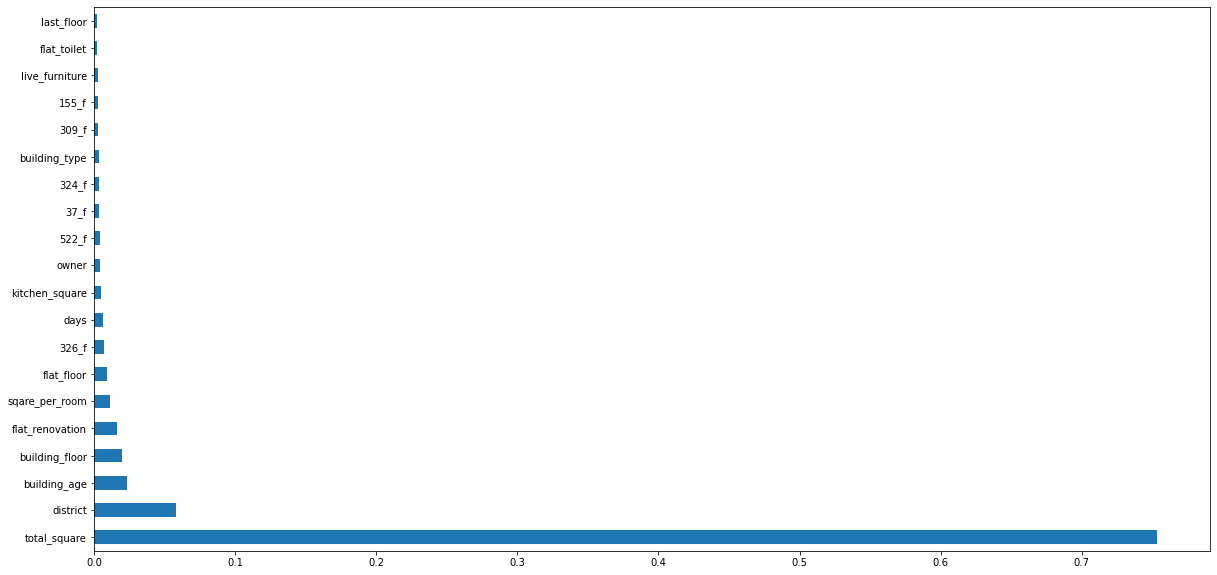

In [188]:
# Выведем самые важные признаки для RandomForestRegressor
plt.rcParams['figure.figsize'] = (20,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Подбор гиперпараметров

In [189]:
# print('Параметры по умолчанию:\n')
# pprint(model.get_params())

In [190]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [191]:
# my_scorer = make_scorer(mape, greater_is_better=False)

In [192]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf,
#                                param_distributions=random_grid,
#                                n_iter=100,
#                                scoring=my_scorer,
#                                cv=3, 
#                                verbose=2,
#                                random_state=RANDOM_SEED,
#                                n_jobs=-1)
# rf_random.fit(X_train, y_train)

In [193]:
# rf_random.best_params_

Random Forest с подобранными параметрами:

In [194]:
rf_optim = RandomForestRegressor(random_state=RANDOM_SEED,
                                 verbose=1,
                                 n_jobs=-1,
                                 n_estimators=1400,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=100,
                                 bootstrap=True)

In [195]:
rf_optim.fit(X_train, y_train)

y_pred = rf_optim.predict(X_test)
y_pred_train = rf_optim.predict(X_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 14.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 1400 out of 1400 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

In [196]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 2.564968755651193


In [197]:
print('MAE_train:', metrics.mean_absolute_error(y_train, y_pred_train))

MAE_train: 0.9622522718376604


In [198]:
print('MAPE:', 100*mape(y_test, y_pred), '%')

MAPE: 7.319832166722446 %


In [199]:
print('MAPE_train:', 100*mape(y_train, y_pred_train), '%')

MAPE_train: 2.7456567679299866 %


С логарифмированием целевой переменной

In [200]:
y_train = np.log(y_train)

In [201]:
rf_optim = RandomForestRegressor(random_state=RANDOM_SEED,
                                 verbose=1,
                                 n_jobs=-1,
                                 n_estimators=1400,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=100,
                                 bootstrap=True)

In [202]:
rf_optim.fit(X_train, y_train)


y_pred = rf_optim.predict(X_test)
y_pred = np.exp(y_pred)
y_pred_train = rf_optim.predict(X_train)
y_pred_train = np.exp(y_pred_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 13.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 1400 out of 1400 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

In [203]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 2.5526056899123466


In [204]:
print('MAE_train:', metrics.mean_absolute_error(np.exp(y_train), y_pred_train))

MAE_train: 0.9713706768834204


In [205]:
print('MAPE:', 100*mape(y_test, y_pred), '%')

MAPE: 7.162373411888237 %


In [206]:
print('MAPE_train:', 100*mape(np.exp(y_train), y_pred_train), '%')

MAPE_train: 2.667636908014306 %


## Выводы

### Благодаря хорошему качеству Front End кода сайта krisha.kz нам удалось "спарсить" качественный набор данных для обучения модели.
### Лучший результат на семействах моделей RandomForest Regressor получился с применением логарифмирования целевой переменной и подбора гиперпараметров и составил 7.16 % по метрике MAPE.